In [1]:
import os, sys
import warnings


warnings.filterwarnings(
    "ignore", category=UserWarning, module="torchvision.io.image", lineno=13
)
warnings.filterwarnings(
    "ignore",
    message="The installed version of bitsandbytes was compiled without GPU support.*",
    category=UserWarning,
    module='bitsandbytes.cextension'
)
warnings.filterwarnings("ignore")
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="This implementation of AdamW is deprecated",
)

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["NUMEXPR_MAX_THREADS"] = "28"
os.environ["ENABLE_SDP_FUSION"] = "true"
os.environ["SYCL_PI_LEVEL_ZERO_USE_IMMEDIATE_COMMANDLISTS"]="1"

In [2]:
from datasets import load_dataset
import torch
device = torch.device("cpu")
emotions = load_dataset("dair-ai/emotion", trust_remote_code=True , download_mode='force_redownload')

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

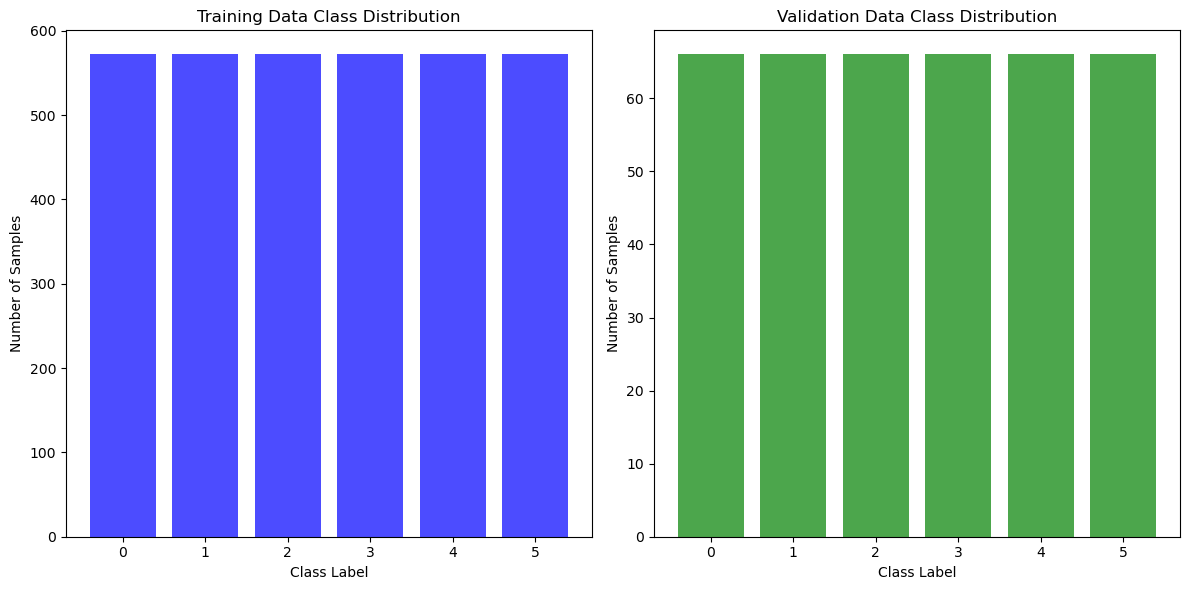

In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt

    
train_data = emotions['train']
val_data = emotions['test']
# Calculate class distributions
train_class_distribution = count_class_distribution(train_data)
val_class_distribution = count_class_distribution(val_data)
            
# Get class labels and counts for training and validation data
train_labels, train_counts = zip(*train_class_distribution.items())
val_labels, val_counts = zip(*val_class_distribution.items())
            
# Plotting the distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            
ax1.bar(train_labels, train_counts, color='blue', alpha=0.7)
ax1.set_title('Training Data Class Distribution')
ax1.set_xlabel('Class Label')
ax1.set_ylabel('Number of Samples')
            
ax2.bar(val_labels, val_counts, color='green', alpha=0.7)
ax2.set_title('Validation Data Class Distribution')
ax2.set_xlabel('Class Label')
ax2.set_ylabel('Number of Samples')
            
plt.tight_layout()
plt.show()

In [6]:
from transformers import AutoTokenizer

model_name = "openlm-research/open_llama_3b_v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggin

In [7]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [8]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device))

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at openlm-research/open_llama_3b_v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
emotions_encoded["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [10]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_encoded["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [11]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [15]:
from transformers import Trainer, TrainingArguments
import torch.optim as optim

batch_size = 16
logging_steps = len(emotions_encoded["train"]) // batch_size
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  optim='adam_hf',
                                  report_to=[])
                                  #bf16=True,
                                  #use_ipex=True)

In [16]:
from peft import get_peft_model, LoraConfig, PeftModel

LORA_CONFIG = LoraConfig(
    r=8, 
    lora_alpha=16, 
    #target_modules=["query", "value"], 
    target_modules = ["q_proj", "k_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
)

model = get_peft_model(model, LORA_CONFIG)

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"])
trainer.train(); 

Epoch,Training Loss,Validation Loss


In [13]:
results = trainer.evaluate() #without lora 0.935
results

{'eval_loss': 7.214023590087891,
 'eval_accuracy': 0.089,
 'eval_f1': 0.014547291092745638,
 'eval_runtime': 2.4993,
 'eval_samples_per_second': 800.211,
 'eval_steps_per_second': 12.803,
 'epoch': 8.0}

In [14]:
preds_output = trainer.predict(emotions_encoded["test"])
preds_output.metrics #without lora 0.935

{'test_loss': 7.272813320159912,
 'test_accuracy': 0.0795,
 'test_f1': 0.011709587772116723,
 'test_runtime': 2.2794,
 'test_samples_per_second': 877.443,
 'test_steps_per_second': 14.039}

In [ ]:
import numpy as np
from sklearn.metrics import plot_confusion_matrix
y_valid = np.array(emotions_encoded["validation"]["label"])
y_preds = np.argmax(preds_output.predictions, axis=1)
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
plot_confusion_matrix(y_preds, y_valid, labels)

In [15]:
model.save_pretrained('./f70_model')
tokenizer.save_pretrained('./f70_model')

('./f70_model/tokenizer_config.json',
 './f70_model/special_tokens_map.json',
 './f70_model/vocab.txt',
 './f70_model/added_tokens.json',
 './f70_model/tokenizer.json')

In [16]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

model_pat = "./f70_model"

model = AutoModelForSequenceClassification.from_pretrained(model_pat, num_labels=6)
tokenizer = AutoTokenizer.from_pretrained(model_pat)

inputs = "i think someone is outside the house"
inputs = tokenizer(inputs, padding='max_length', truncation=True, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predicted_class = logits.argmax(dim=-1).item()
print(outputs)
print("Predicted class:", predicted_class)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SequenceClassifierOutput(loss=None, logits=tensor([[ 0.2464, -1.5994, -0.1093,  1.6364,  1.0874, -0.8059]]), hidden_states=None, attentions=None)
Predicted class: 3
